In [16]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MyApp") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

print(spark.version)


3.5.0


In [17]:
df = spark.read.csv("hdfs://namenode:8020/data/Iris.csv", header=True, inferSchema=True)
df.show(5)

+---+-------------+------------+-------------+------------+-----------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|
+---+-------------+------------+-------------+------------+-----------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|
|  4|          4.6|         3.1|          1.5|         0.2|Iris-setosa|
|  5|          5.0|         3.6|          1.4|         0.2|Iris-setosa|
+---+-------------+------------+-------------+------------+-----------+
only showing top 5 rows



In [18]:
df = df.drop("Id")
df.printSchema()


root
 |-- SepalLengthCm: double (nullable = true)
 |-- SepalWidthCm: double (nullable = true)
 |-- PetalLengthCm: double (nullable = true)
 |-- PetalWidthCm: double (nullable = true)
 |-- Species: string (nullable = true)



In [19]:
from pyspark.ml.feature import StringIndexer

label_indexer = StringIndexer(inputCol="Species", outputCol="label")
df_indexed = label_indexer.fit(df).transform(df)
df_indexed.select("Species", "label").show(5)


+-----------+-----+
|    Species|label|
+-----------+-----+
|Iris-setosa|  0.0|
|Iris-setosa|  0.0|
|Iris-setosa|  0.0|
|Iris-setosa|  0.0|
|Iris-setosa|  0.0|
+-----------+-----+
only showing top 5 rows



In [20]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"],
    outputCol="features"
)

df_final = assembler.transform(df_indexed)
df_final.select("features", "label").show(5, truncate=False)


+-----------------+-----+
|features         |label|
+-----------------+-----+
|[5.1,3.5,1.4,0.2]|0.0  |
|[4.9,3.0,1.4,0.2]|0.0  |
|[4.7,3.2,1.3,0.2]|0.0  |
|[4.6,3.1,1.5,0.2]|0.0  |
|[5.0,3.6,1.4,0.2]|0.0  |
+-----------------+-----+
only showing top 5 rows



In [23]:
train_data, test_data = df_final.randomSplit([0.7, 0.3], seed=42)


In [27]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

# Create pipeline
pipeline = Pipeline(stages=[ dt])

# Fit model
model = pipeline.fit(train_data)


### We can do everything from scratch in the pipeline

In [ ]:
# from pyspark.ml import Pipeline

# # Refit label indexer on raw data
# label_indexer = StringIndexer(inputCol="Species", outputCol="label")
# assembler = VectorAssembler(inputCols=["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"], outputCol="features")
# dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

# # Create the full pipeline
# pipeline = Pipeline(stages=[label_indexer, assembler, dt])

# # Split from the original DataFrame
# train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

# # Fit
# model = pipeline.fit(train_data)


In [28]:
predictions = model.transform(test_data)
predictions.select("features", "label", "prediction").show(5)


+-----------------+-----+----------+
|         features|label|prediction|
+-----------------+-----+----------+
|[4.4,3.0,1.3,0.2]|  0.0|       0.0|
|[4.6,3.2,1.4,0.2]|  0.0|       0.0|
|[4.6,3.6,1.0,0.2]|  0.0|       0.0|
|[4.7,3.2,1.3,0.2]|  0.0|       0.0|
|[4.8,3.1,1.6,0.2]|  0.0|       0.0|
+-----------------+-----+----------+
only showing top 5 rows



In [29]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.2f}")


Test Accuracy: 0.98


In [30]:
pandas_df = predictions.select("label", "prediction").toPandas()


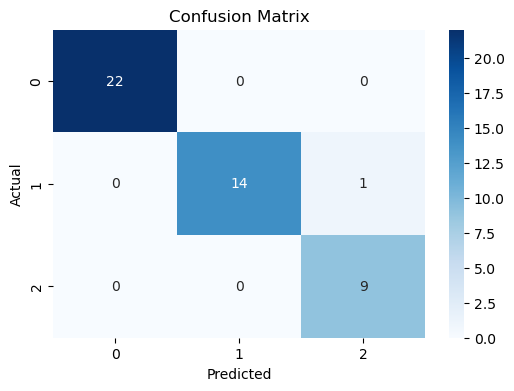

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(pandas_df["label"], pandas_df["prediction"])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
